In [1]:
import os
import math
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# ============================================================
# 1. CPU-ONLY DEVICE
# ============================================================
DEVICE = torch.device("cpu")
print("Device:", DEVICE)

# ============================================================
# 2. CONFIGURATION
# ============================================================
ROOT = "/Users/Ankan/Desktop/Magnet_Challenge_2/Training Data/78/Training Data/3C90"     # <-- Update if folder path differs
MAT_PREFIX = "3C90"

FREQS = [1, 2, 3, 4, 5, 6, 7]
SEQ_LEN = 80
STRIDE = 5

BATCH_SIZE = 128       # Smaller batch for CPU
EPOCHS = 60            # Reduce epochs so CPU training is fast
LR = 1e-3
PATIENCE = 12

# ============================================================
# 3. HELPERS
# ============================================================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def load_1d(path: str) -> np.ndarray:
    arr = pd.read_csv(path, header=None).values.squeeze()
    return np.asarray(arr, dtype=np.float32).reshape(-1)


# ============================================================
# 4. DATASET
# ============================================================

class CoreFreqDataset(Dataset):
    """
    Dataset for 3C90 frequency data.
    """

    def __init__(self, root, mat_prefix, freq, seq_len=80, stride=5):
        super().__init__()
        self.seq_len = seq_len

        # File paths
        B_path = os.path.join(root, f"{mat_prefix}_{freq}_B.csv")
        H_path = os.path.join(root, f"{mat_prefix}_{freq}_H.csv")
        T_path = os.path.join(root, f"{mat_prefix}_{freq}_T.csv")

        if not (os.path.exists(B_path) and os.path.exists(H_path) and os.path.exists(T_path)):
            raise FileNotFoundError(f"Missing CSVs for freq {freq}")

        B = load_1d(B_path)
        H = load_1d(H_path)
        T = load_1d(T_path)

        # Handle unequal length (seen in Kaggle)
        Lmin = min(len(B), len(H), len(T))
        if not (len(B) == len(H) == len(T)):
            print(f"[Warning] lengths differ for freq {freq}, truncating to {Lmin}")
            B, H, T = B[:Lmin], H[:Lmin], T[:Lmin]

        # Compute dB/dt
        dBdt = np.gradient(B).astype(np.float32)

        # Normalize
        self.B_mean, self.B_std = float(B.mean()), float(B.std() + 1e-8)
        self.H_mean, self.H_std = float(H.mean()), float(H.std() + 1e-8)
        self.dB_mean, self.dB_std = float(dBdt.mean()), float(dBdt.std() + 1e-8)

        Bn = (B - self.B_mean) / self.B_std
        Hn = (H - self.H_mean) / self.H_std
        dBn = (dBdt - self.dB_mean) / self.dB_std

        # Build sliding windows
        self.inputs = []
        self.targets = []

        N = len(Bn)
        for i in range(N - seq_len):
            x = np.stack([Bn[i:i+seq_len], Hn[i:i+seq_len], dBn[i:i+seq_len]], axis=-1)
            y = Hn[i + seq_len]
            self.inputs.append(x.astype(np.float32))
            self.targets.append(np.float32(y))

        self.inputs = np.stack(self.inputs)
        self.targets = np.stack(self.targets)

        print(f"[3C90] freq {freq}: windows = {len(self.inputs)}")

    def __len__(self): 
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

    @property
    def y_mean(self): return self.H_mean

    @property
    def y_std(self): return self.H_std


# ============================================================
# 5. MODEL
# ============================================================

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1]
        return self.fc(last).squeeze(-1)


# ============================================================
# 6. TRAINING FUNCTION
# ============================================================

def train_one_frequency(freq):

    try:
        full_ds = CoreFreqDataset(ROOT, MAT_PREFIX, freq, seq_len=SEQ_LEN)
    except FileNotFoundError as e:
        print(e)
        return None

    if len(full_ds) < 20:
        print(f"Skipping freq {freq}; not enough windows.")
        return None

    # Train/val split
    N = len(full_ds)
    Ntrain = int(0.8 * N)
    train_ds, val_ds = random_split(full_ds, [Ntrain, N - Ntrain])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = LSTMPredictor().to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    patience_counter = 0
    best_state = None

    print(f"\n========== Training 3C90 freq {freq} on CPU ==========")

    for epoch in range(1, EPOCHS + 1):

        # Training
        model.train()
        t_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optim.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optim.step()
            t_losses.append(loss.item())

        # Validation
        model.eval()
        v_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)
                v_losses.append(loss_fn(pred, yb).item())

        train_loss = np.mean(t_losses)
        val_loss = np.mean(v_losses)

        print(f"Epoch {epoch:3d}: train={train_loss:.5f}, val={val_loss:.5f}")

        # Early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_state)

    # Save model
    fname = f"3C90_freq{freq}.pt"
    torch.save(best_state, fname)
    print(f"Saved CPU model: {fname}")

    # Evaluation (physical units)
    all_loader = DataLoader(full_ds, batch_size=256, shuffle=False)
    preds, targs = [], []

    model.eval()
    with torch.no_grad():
        for xb, yb in all_loader:
            preds.append(model(xb.to(DEVICE)).numpy())
            targs.append(yb.numpy())

    preds = np.concatenate(preds)
    targs = np.concatenate(targs)

    # Denormalize
    preds_phys = preds * full_ds.y_std + full_ds.y_mean
    targs_phys = targs * full_ds.y_std + full_ds.y_mean

    rmse = np.sqrt(np.mean((preds_phys - targs_phys)**2))
    rel = rmse / np.sqrt(np.mean(targs_phys**2)) * 100

    print(f"[3C90 f={freq}] RMSE={rmse:.4f}, Rel.Err={rel:.2f}%")

    return model, full_ds, rmse, rel


# ============================================================
# 7. MAIN LOOP
# ============================================================

if __name__ == "__main__":
    set_seed(42)
    for f in FREQS:
        train_one_frequency(f)


Device: cpu
[Warning] lengths differ for freq 1, truncating to 647
[3C90] freq 1: windows = 567

========== Training 3C90 freq 1 on CPU ==========
Epoch   1: train=1.02015, val=0.91586
Epoch   2: train=0.94764, val=0.84352
Epoch   3: train=0.88089, val=0.76975
Epoch   4: train=0.80164, val=0.69177
Epoch   5: train=0.73310, val=0.60673
Epoch   6: train=0.63121, val=0.51354
Epoch   7: train=0.54601, val=0.41271
Epoch   8: train=0.43495, val=0.31389
Epoch   9: train=0.34039, val=0.24037
Epoch  10: train=0.27510, val=0.21072
Epoch  11: train=0.23405, val=0.17251
Epoch  12: train=0.18002, val=0.12053
Epoch  13: train=0.13249, val=0.09350
Epoch  14: train=0.10608, val=0.07660
Epoch  15: train=0.08317, val=0.05922
Epoch  16: train=0.06815, val=0.04572
Epoch  17: train=0.05647, val=0.03656
Epoch  18: train=0.04317, val=0.02711
Epoch  19: train=0.02995, val=0.01984
Epoch  20: train=0.02063, val=0.01559
Epoch  21: train=0.01544, val=0.01246
Epoch  22: train=0.01153, val=0.01011
Epoch  23: train=

In [3]:
import os
import math
import random
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# ============================================================
# 1. CPU-ONLY DEVICE
# ============================================================
DEVICE = torch.device("cpu")
print("Device:", DEVICE)

# ============================================================
# 2. CONFIGURATION
# ============================================================
ROOT = "/Users/Ankan/Desktop/Magnet_Challenge_2/Training Data/78/Training Data/3C94"     # <-- Update if folder path differs
MAT_PREFIX = "3C94"

FREQS = [1, 2, 3, 4, 5, 6, 7]
SEQ_LEN = 80
STRIDE = 5

BATCH_SIZE = 128       # Smaller batch for CPU
EPOCHS = 60            # Reduce epochs so CPU training is fast
LR = 1e-3
PATIENCE = 12

# ============================================================
# 3. HELPERS
# ============================================================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def load_1d(path: str) -> np.ndarray:
    arr = pd.read_csv(path, header=None).values.squeeze()
    return np.asarray(arr, dtype=np.float32).reshape(-1)


# ============================================================
# 4. DATASET
# ============================================================

class CoreFreqDataset(Dataset):
    """
    Dataset for 3C94 frequency data.
    """

    def __init__(self, root, mat_prefix, freq, seq_len=80, stride=5):
        super().__init__()
        self.seq_len = seq_len

        # File paths
        B_path = os.path.join(root, f"{mat_prefix}_{freq}_B.csv")
        H_path = os.path.join(root, f"{mat_prefix}_{freq}_H.csv")
        T_path = os.path.join(root, f"{mat_prefix}_{freq}_T.csv")

        if not (os.path.exists(B_path) and os.path.exists(H_path) and os.path.exists(T_path)):
            raise FileNotFoundError(f"Missing CSVs for freq {freq}")

        B = load_1d(B_path)
        H = load_1d(H_path)
        T = load_1d(T_path)

        # Handle unequal length (seen in Kaggle)
        Lmin = min(len(B), len(H), len(T))
        if not (len(B) == len(H) == len(T)):
            print(f"[Warning] lengths differ for freq {freq}, truncating to {Lmin}")
            B, H, T = B[:Lmin], H[:Lmin], T[:Lmin]

        # Compute dB/dt
        dBdt = np.gradient(B).astype(np.float32)

        # Normalize
        self.B_mean, self.B_std = float(B.mean()), float(B.std() + 1e-8)
        self.H_mean, self.H_std = float(H.mean()), float(H.std() + 1e-8)
        self.dB_mean, self.dB_std = float(dBdt.mean()), float(dBdt.std() + 1e-8)

        Bn = (B - self.B_mean) / self.B_std
        Hn = (H - self.H_mean) / self.H_std
        dBn = (dBdt - self.dB_mean) / self.dB_std

        # Build sliding windows
        self.inputs = []
        self.targets = []

        N = len(Bn)
        for i in range(N - seq_len):
            x = np.stack([Bn[i:i+seq_len], Hn[i:i+seq_len], dBn[i:i+seq_len]], axis=-1)
            y = Hn[i + seq_len]
            self.inputs.append(x.astype(np.float32))
            self.targets.append(np.float32(y))

        self.inputs = np.stack(self.inputs)
        self.targets = np.stack(self.targets)

        print(f"[3C94] freq {freq}: windows = {len(self.inputs)}")

    def __len__(self): 
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

    @property
    def y_mean(self): return self.H_mean

    @property
    def y_std(self): return self.H_std


# ============================================================
# 5. MODEL
# ============================================================

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1]
        return self.fc(last).squeeze(-1)


# ============================================================
# 6. TRAINING FUNCTION
# ============================================================

def train_one_frequency(freq):

    try:
        full_ds = CoreFreqDataset(ROOT, MAT_PREFIX, freq, seq_len=SEQ_LEN)
    except FileNotFoundError as e:
        print(e)
        return None

    if len(full_ds) < 20:
        print(f"Skipping freq {freq}; not enough windows.")
        return None

    # Train/val split
    N = len(full_ds)
    Ntrain = int(0.8 * N)
    train_ds, val_ds = random_split(full_ds, [Ntrain, N - Ntrain])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = LSTMPredictor().to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    patience_counter = 0
    best_state = None

    print(f"\n========== Training 3C90 freq {freq} on CPU ==========")

    for epoch in range(1, EPOCHS + 1):

        # Training
        model.train()
        t_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optim.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optim.step()
            t_losses.append(loss.item())

        # Validation
        model.eval()
        v_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                pred = model(xb)
                v_losses.append(loss_fn(pred, yb).item())

        train_loss = np.mean(t_losses)
        val_loss = np.mean(v_losses)

        print(f"Epoch {epoch:3d}: train={train_loss:.5f}, val={val_loss:.5f}")

        # Early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_state)

    # Save model
    fname = f"3C94_freq{freq}.pt"
    torch.save(best_state, fname)
    print(f"Saved CPU model: {fname}")

    # Evaluation (physical units)
    all_loader = DataLoader(full_ds, batch_size=256, shuffle=False)
    preds, targs = [], []

    model.eval()
    with torch.no_grad():
        for xb, yb in all_loader:
            preds.append(model(xb.to(DEVICE)).numpy())
            targs.append(yb.numpy())

    preds = np.concatenate(preds)
    targs = np.concatenate(targs)

    # Denormalize
    preds_phys = preds * full_ds.y_std + full_ds.y_mean
    targs_phys = targs * full_ds.y_std + full_ds.y_mean

    rmse = np.sqrt(np.mean((preds_phys - targs_phys)**2))
    rel = rmse / np.sqrt(np.mean(targs_phys**2)) * 100

    print(f"[3C94 f={freq}] RMSE={rmse:.4f}, Rel.Err={rel:.2f}%")

    return model, full_ds, rmse, rel


# ============================================================
# 7. MAIN LOOP
# ============================================================

if __name__ == "__main__":
    set_seed(42)
    for f in FREQS:
        train_one_frequency(f)


Device: cpu
[Warning] lengths differ for freq 1, truncating to 1108
[3C94] freq 1: windows = 1028

========== Training 3C90 freq 1 on CPU ==========
Epoch   1: train=0.93461, val=0.93467
Epoch   2: train=0.82268, val=0.79188
Epoch   3: train=0.67978, val=0.62906
Epoch   4: train=0.51348, val=0.44153
Epoch   5: train=0.32667, val=0.25562
Epoch   6: train=0.18334, val=0.13509
Epoch   7: train=0.10629, val=0.09394
Epoch   8: train=0.08431, val=0.08463
Epoch   9: train=0.06454, val=0.05056
Epoch  10: train=0.04256, val=0.03703
Epoch  11: train=0.03220, val=0.02627
Epoch  12: train=0.02130, val=0.01732
Epoch  13: train=0.01386, val=0.01266
Epoch  14: train=0.00924, val=0.00805
Epoch  15: train=0.00641, val=0.00594
Epoch  16: train=0.00482, val=0.00444
Epoch  17: train=0.00377, val=0.00390
Epoch  18: train=0.00315, val=0.00326
Epoch  19: train=0.00283, val=0.00297
Epoch  20: train=0.00247, val=0.00278
Epoch  21: train=0.00239, val=0.00256
Epoch  22: train=0.00216, val=0.00242
Epoch  23: trai

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ============================================================
# Config
# ============================================================

DEVICE = torch.device("cpu")  # force CPU as requested
print("Device:", DEVICE)

ROOT = "/Users/Ankan/Desktop/Magnet_Challenge_2/Training Data/78/Training Data"   # folder that contains 3C90, 3C94, 3E6, 3F4, ...

MATERIALS = ["3C90", "3C94", "3E6", "3F4", "77", "78", "N27", "N30", "N49", "N87"]
FREQS = [1, 2, 3, 4, 5, 6, 7]

SEQ_LEN = 80
STRIDE = 5

BATCH_SIZE = 256
EPOCHS = 80
LR = 1e-3
PATIENCE = 20

MAT_EMB_DIM = 8
FREQ_EMB_DIM = 4
LSTM_HIDDEN = 32
LSTM_LAYERS = 1
MLP_HIDDEN = 64


# ============================================================
# Helpers
# ============================================================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def load_1d(path: str) -> np.ndarray:
    """Load a 1D csv file (no header) as float32 np.array."""
    arr = pd.read_csv(path, header=None).values.squeeze()
    arr = np.asarray(arr, dtype=np.float32).reshape(-1)
    return arr


# ============================================================
# Dataset: all materials + freqs in one big dataset
# ============================================================

class GlobalDataset(Dataset):
    """
    Each sample:
      x_seq   : (seq_len, 3) = [B_norm, H_norm, dBdt_norm]
      mat_id  : int index into MATERIALS
      freq_id : int index into FREQS
      y       : scalar normalized H at (t + seq_len)
      H_mean, H_std : floats (for de-normalising to physical units)
    """

    def __init__(self, root, materials, freqs, seq_len=80, stride=5):
        super().__init__()
        self.seq_len = seq_len
        self.stride = stride
        self.materials = materials
        self.freqs = freqs

        self.inputs = []
        self.mat_ids = []
        self.freq_ids = []
        self.targets = []
        self.H_means = []
        self.H_stds = []

        for m_idx, mat in enumerate(materials):
            for f_idx, freq in enumerate(freqs):
                B_path = os.path.join(root, mat, f"{mat}_{freq}_B.csv")
                H_path = os.path.join(root, mat, f"{mat}_{freq}_H.csv")
                T_path = os.path.join(root, mat, f"{mat}_{freq}_T.csv")

                if not (os.path.exists(B_path) and os.path.exists(H_path) and os.path.exists(T_path)):
                    print(f"Skipping [{mat}, f={freq}]: missing B/H/T CSVs")
                    continue

                B = load_1d(B_path)
                H = load_1d(H_path)
                T = load_1d(T_path)

                lenB, lenH, lenT = len(B), len(H), len(T)
                if not (lenB == lenH == lenT):
                    min_len = min(lenB, lenH, lenT)
                    print(
                        f"Warning [{mat}, f={freq}]: "
                        f"B/H/T lengths differ (B={lenB}, H={lenH}, T={lenT}) "
                        f"-> truncating to {min_len}"
                    )
                    B = B[:min_len]
                    H = H[:min_len]
                    T = T[:min_len]

                B = np.asarray(B, dtype=np.float32).reshape(-1)
                H = np.asarray(H, dtype=np.float32).reshape(-1)
                dBdt = np.gradient(B).astype(np.float32)

                B_mean, B_std = float(B.mean()), float(B.std() + 1e-8)
                H_mean, H_std = float(H.mean()), float(H.std() + 1e-8)
                dB_mean, dB_std = float(dBdt.mean()), float(dBdt.std() + 1e-8)

                Bn = (B - B_mean) / B_std
                Hn = (H - H_mean) / H_std
                dBn = (dBdt - dB_mean) / dB_std

                n = len(Bn)
                count_windows = 0
                for start in range(0, n - seq_len):
                    end = start + seq_len
                    if end >= n:
                        break

                    x = np.stack([Bn[start:end], Hn[start:end], dBn[start:end]], axis=-1)
                    y = Hn[end]

                    self.inputs.append(x.astype(np.float32))
                    self.targets.append(np.float32(y))
                    self.mat_ids.append(m_idx)
                    self.freq_ids.append(f_idx)
                    self.H_means.append(H_mean)
                    self.H_stds.append(H_std)
                    count_windows += 1

                print(f"[{mat}, f={freq}] windows added: {count_windows} (series length {n})")

        self.inputs = np.stack(self.inputs, axis=0)
        self.targets = np.stack(self.targets, axis=0)
        self.mat_ids = np.array(self.mat_ids, dtype=np.int64)
        self.freq_ids = np.array(self.freq_ids, dtype=np.int64)
        self.H_means = np.array(self.H_means, dtype=np.float32)
        self.H_stds = np.array(self.H_stds, dtype=np.float32)

        print(f"\nTotal samples in GlobalDataset: {len(self.inputs)}")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.targets[idx]
        mat_id = self.mat_ids[idx]
        freq_id = self.freq_ids[idx]
        h_mean = self.H_means[idx]
        h_std = self.H_stds[idx]

        return (
            torch.from_numpy(x),
            torch.tensor(mat_id, dtype=torch.long),
            torch.tensor(freq_id, dtype=torch.long),
            torch.from_numpy(np.array(y)),
            torch.tensor(h_mean, dtype=torch.float32),
            torch.tensor(h_std, dtype=torch.float32),
        )


# ============================================================
# Model: LSTM + material & frequency embeddings
# ============================================================

class GlobalLSTM(nn.Module):
    def __init__(
        self,
        input_dim=3,
        lstm_hidden=LSTM_HIDDEN,
        lstm_layers=LSTM_LAYERS,
        num_materials=len(MATERIALS),
        num_freqs=len(FREQS),
        mat_emb_dim=MAT_EMB_DIM,
        freq_emb_dim=FREQ_EMB_DIM,
        mlp_hidden=MLP_HIDDEN,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
        )
        self.mat_emb = nn.Embedding(num_materials, mat_emb_dim)
        self.freq_emb = nn.Embedding(num_freqs, freq_emb_dim)

        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden + mat_emb_dim + freq_emb_dim, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1),
        )

    def forward(self, x_seq, mat_ids, freq_ids):
        # x_seq: (B, L, 3)
        lstm_out, _ = self.lstm(x_seq)           # (B, L, H)
        h_last = lstm_out[:, -1, :]              # (B, H)

        e_mat = self.mat_emb(mat_ids)            # (B, mat_emb_dim)
        e_freq = self.freq_emb(freq_ids)         # (B, freq_emb_dim)

        feat = torch.cat([h_last, e_mat, e_freq], dim=-1)
        y = self.fc(feat).squeeze(-1)            # (B,)
        return y


# ============================================================
# Training and evaluation
# ============================================================

def train_global_model():
    set_seed(42)

    dataset = GlobalDataset(ROOT, MATERIALS, FREQS, seq_len=SEQ_LEN, stride=STRIDE)

    # train/val split
    n_total = len(dataset)
    n_train = int(0.8 * n_total)
    n_val = n_total - n_train
    train_ds, val_ds = torch.utils.data.random_split(
        dataset, [n_train, n_val],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    model = GlobalLSTM(
        num_materials=len(MATERIALS),
        num_freqs=len(FREQS),
    ).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_val = float("inf")
    best_state = None
    no_improve = 0

    print("\n========== Training GLOBAL model ==========")
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_losses = []
        for xb, mb, fb, yb, _, _ in train_loader:
            xb = xb.to(DEVICE)
            mb = mb.to(DEVICE)
            fb = fb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            preds = model(xb, mb, fb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, mb, fb, yb, _, _ in val_loader:
                xb = xb.to(DEVICE)
                mb = mb.to(DEVICE)
                fb = fb.to(DEVICE)
                yb = yb.to(DEVICE)
                preds = model(xb, mb, fb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        train_loss = float(np.mean(train_losses))
        val_loss = float(np.mean(val_losses))
        print(f"Epoch {epoch:3d}/{EPOCHS}  train_loss={train_loss:.6f}  val_loss={val_loss:.6f}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"Early stopping at epoch {epoch}. Best val_loss={best_val:.6f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # Save global model
    torch.save(model.state_dict(), "global_lstm_all_materials.pt")
    print("\nSaved global model to: global_lstm_all_materials.pt")

    # --------------------------------------------------------
    # Final evaluation in physical H units per (material, freq)
    # --------------------------------------------------------
    model.eval()
    stats = {}  # (mat_idx, freq_idx) -> {se_sum, y2_sum, count}

    with torch.no_grad():
        for xb, mb, fb, yb, hmean_b, hstd_b in full_loader:
            xb = xb.to(DEVICE)
            mb = mb.to(DEVICE)
            fb = fb.to(DEVICE)
            preds_norm = model(xb, mb, fb).cpu().numpy()
            y_true_norm = yb.numpy()
            hmean = hmean_b.numpy()
            hstd = hstd_b.numpy()

            # de-normalise
            preds_phys = preds_norm * hstd + hmean
            y_true_phys = y_true_norm * hstd + hmean

            se = (preds_phys - y_true_phys) ** 2
            y2 = y_true_phys ** 2

            mb_np = mb.cpu().numpy()
            fb_np = fb.cpu().numpy()

            for i in range(len(preds_phys)):
                key = (int(mb_np[i]), int(fb_np[i]))
                if key not in stats:
                    stats[key] = {"se_sum": 0.0, "y2_sum": 0.0, "count": 0}
                stats[key]["se_sum"] += float(se[i])
                stats[key]["y2_sum"] += float(y2[i])
                stats[key]["count"] += 1

    print("\n===== FINAL RESULTS (per material & frequency) =====")
    overall_se = 0.0
    overall_y2 = 0.0
    overall_count = 0

    for (m_idx, f_idx), d in sorted(stats.items()):
        se_sum = d["se_sum"]
        y2_sum = d["y2_sum"]
        cnt = d["count"]

        rmse = math.sqrt(se_sum / cnt)
        rms_meas = math.sqrt(y2_sum / cnt) + 1e-12
        rel_err = rmse / rms_meas * 100.0

        mat = MATERIALS[m_idx]
        freq = FREQS[f_idx]
        print(f"{mat:4s}  freq {freq}:  RMSE={rmse:.4f},  RelErr={rel_err:.2f}%  (N={cnt})")

        overall_se += se_sum
        overall_y2 += y2_sum
        overall_count += cnt

    overall_rmse = math.sqrt(overall_se / overall_count)
    overall_rms_meas = math.sqrt(overall_y2 / overall_count) + 1e-12
    overall_rel = overall_rmse / overall_rms_meas * 100.0

    print("\n===== OVERALL GLOBAL MODEL =====")
    print(f"RMSE={overall_rmse:.4f},  RelErr={overall_rel:.2f}%  (Total samples={overall_count})")


# ============================================================
# Run
# ============================================================

if __name__ == "__main__":
    train_global_model()


Device: cpu

📌 Computing global normalisation stats from training CSVs...


Materials: 100%|██████████| 10/10 [08:57<00:00, 53.72s/it]



Used triplets: 67
Skipped missing: 3
Skipped empty/bad: 0

Global stats:
  B_mean: 0.000859
  B_std: 0.056539
  H_mean: -0.870553
  H_std: 15.358889
  dB_mean: 0.000006
  dB_std: 0.001092

Model loaded.


PRETEST materials:   0%|          | 0/11 [00:00<?, ?it/s]


=== Evaluating PRETEST for 3C90 using 3C90_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


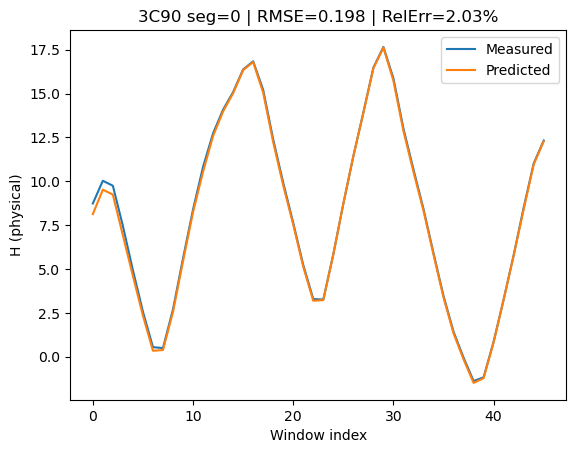

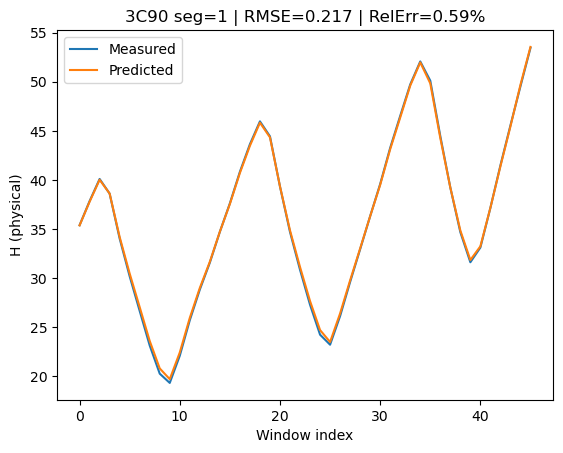

PRETEST materials:   9%|▉         | 1/11 [02:10<21:41, 130.16s/it]


=== Evaluating PRETEST for 3C94 using 3C94_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


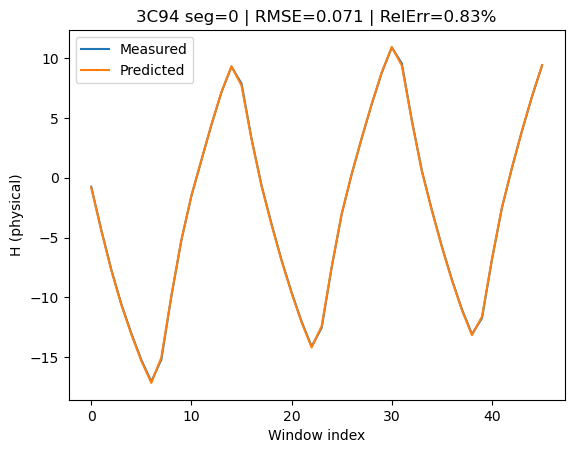

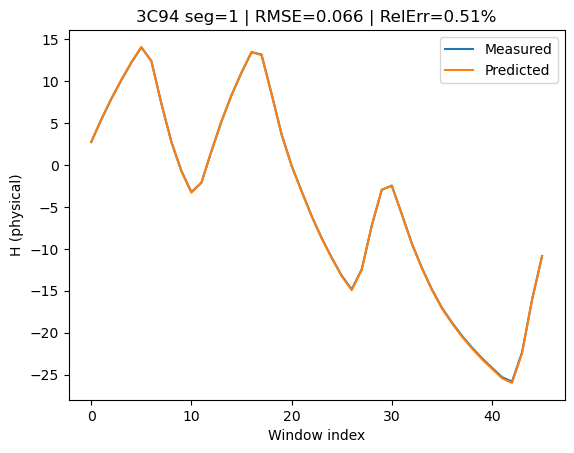

PRETEST materials:  18%|█▊        | 2/11 [04:43<21:33, 143.75s/it]


=== Evaluating PRETEST for 3E6 using 3E6_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


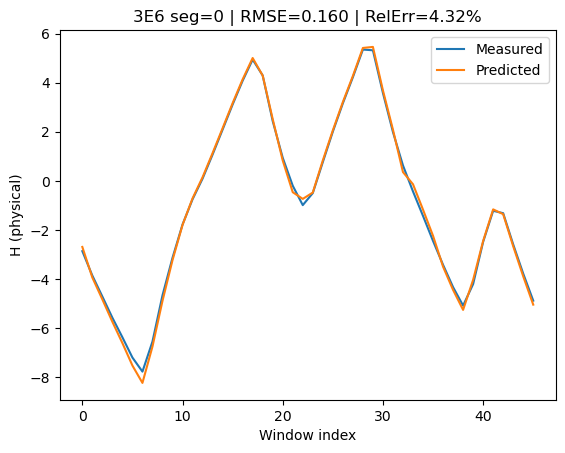

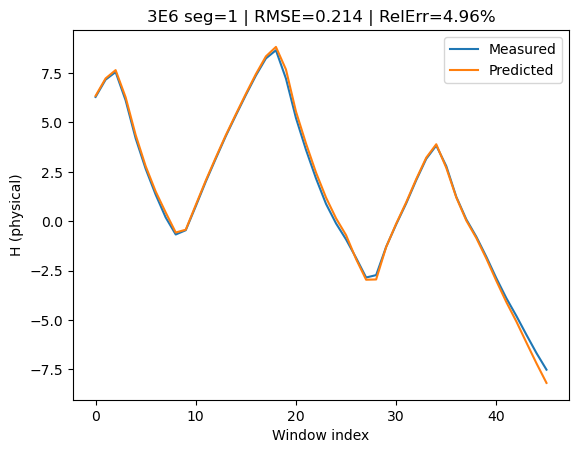

PRETEST materials:  27%|██▋       | 3/11 [07:54<22:01, 165.17s/it]


=== Evaluating PRETEST for 3F4 using 3F4_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


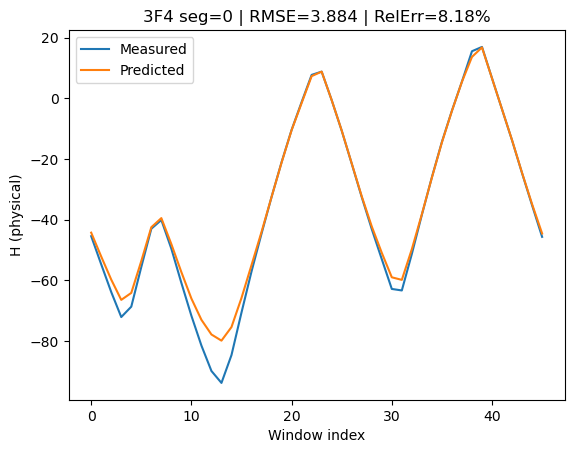

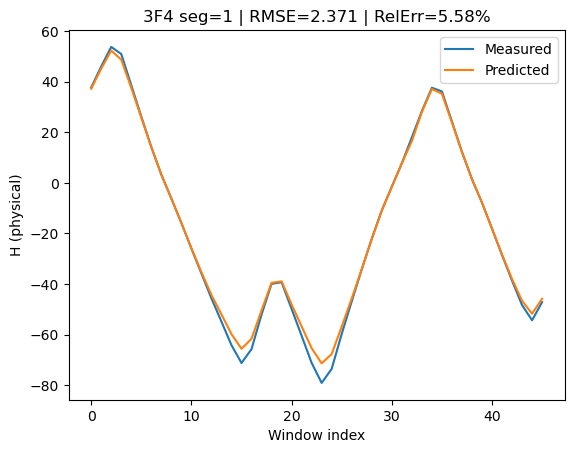

PRETEST materials:  36%|███▋      | 4/11 [11:00<20:16, 173.74s/it]


=== Evaluating PRETEST for 77 using 77_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


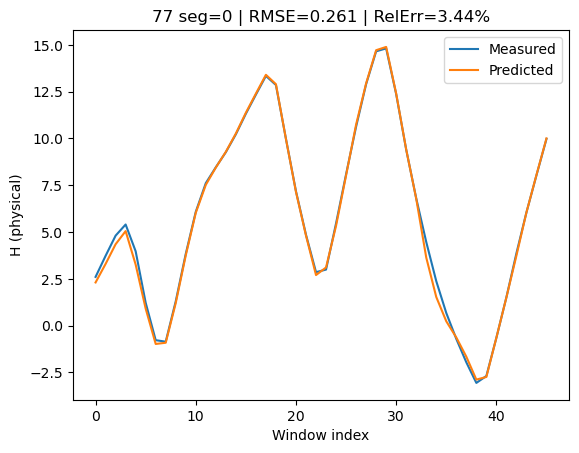

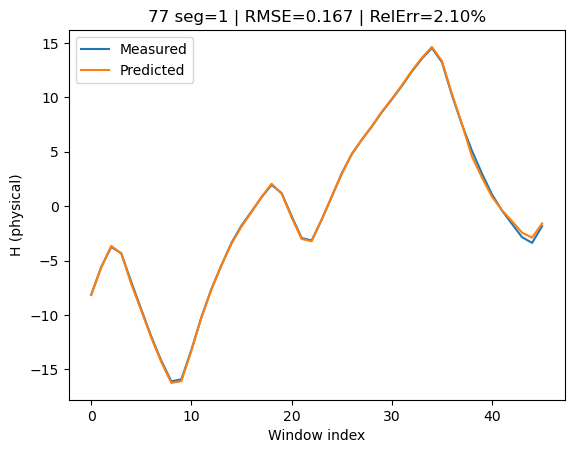

PRETEST materials:  45%|████▌     | 5/11 [13:57<17:28, 174.67s/it]


=== Evaluating PRETEST for 78 using 78_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


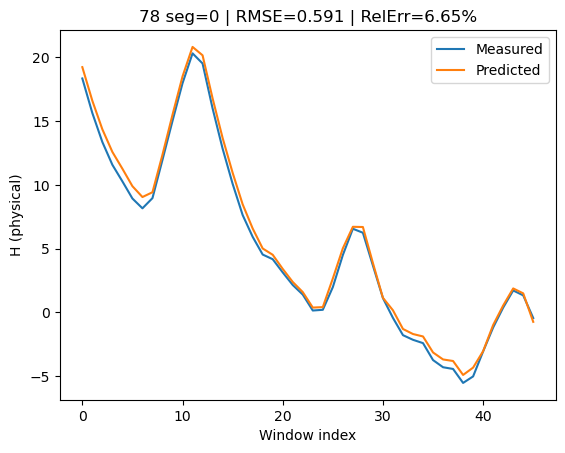

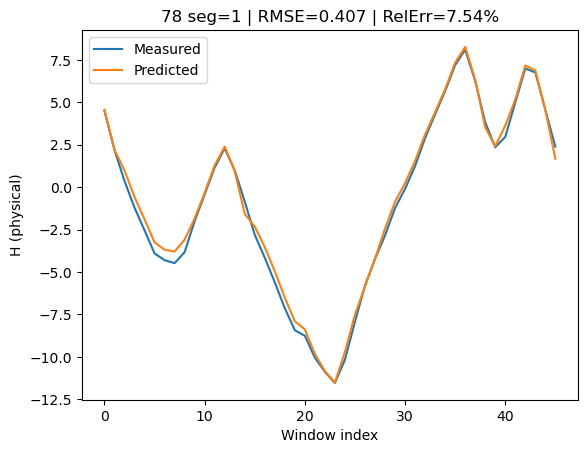

PRETEST materials:  55%|█████▍    | 6/11 [16:38<14:10, 170.10s/it]


=== Evaluating PRETEST for N27 using N27_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


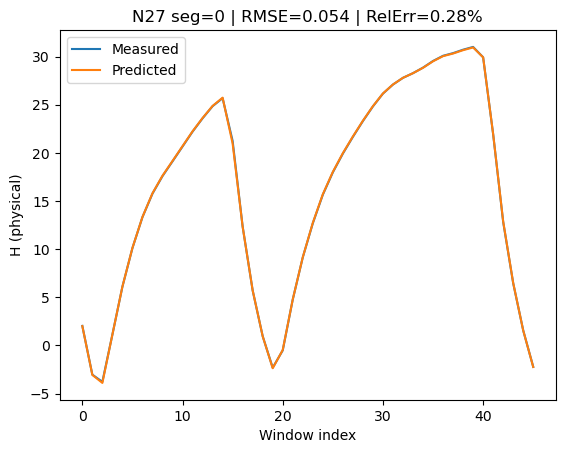

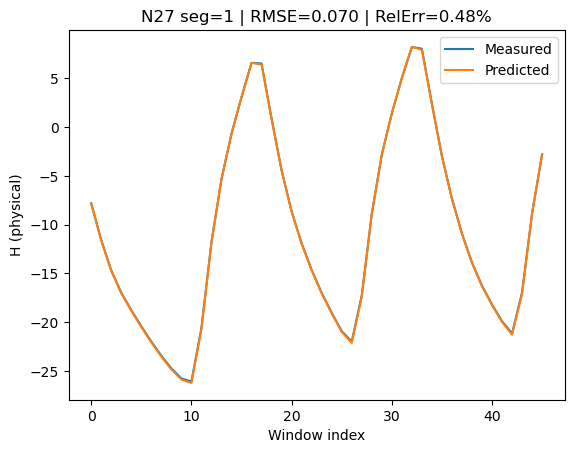

PRETEST materials:  64%|██████▎   | 7/11 [19:21<11:10, 167.69s/it]


=== Evaluating PRETEST for N30 using N30_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


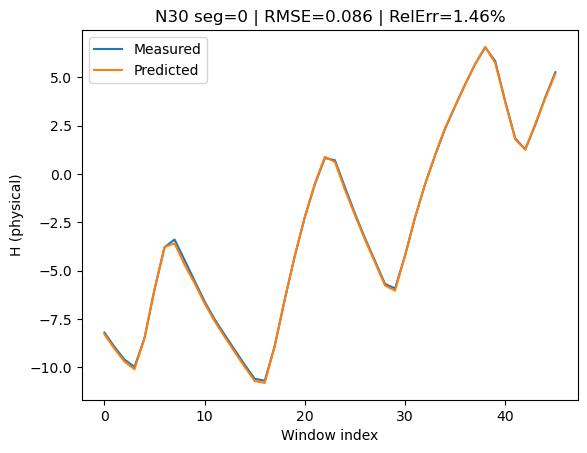

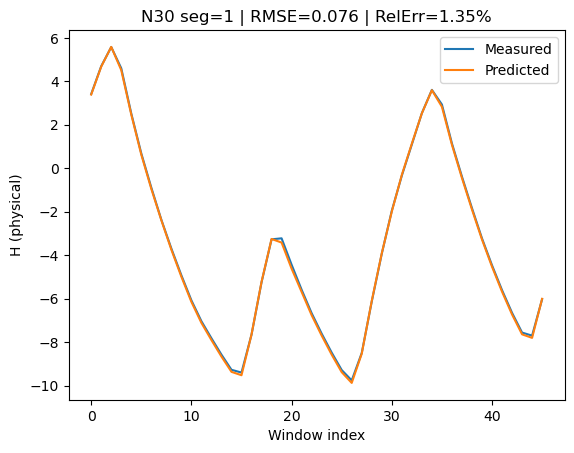

PRETEST materials:  73%|███████▎  | 8/11 [22:03<08:18, 166.11s/it]


=== Evaluating PRETEST for N49 using N49_Testing_True.h5 ===
Found groups: []
   Using ROOT datasets: B='B_seq', H='H_seq'


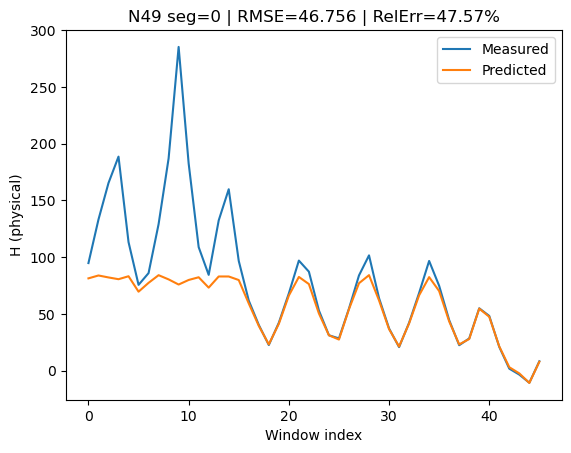

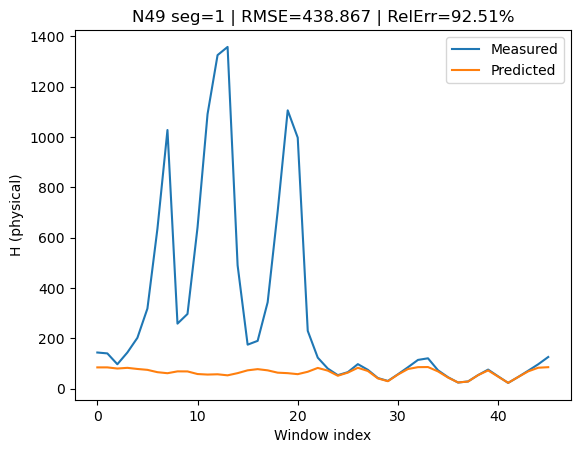

PRETEST materials: 100%|██████████| 11/11 [24:09<00:00, 131.81s/it]


⚠️ [N87] No valid HDF5 file. True=missing | Padded=missing — skipping
⚠️ [N87-2] No valid HDF5 file. True=missing | Padded=missing — skipping

================ PRETEST RESULTS (per segment) ================
material  segment  n_windows       rmse   rel_err            file_used
    3C90        0         46   0.198224  2.030934 3C90_Testing_True.h5
    3C90        1         46   0.217329  0.585899 3C90_Testing_True.h5
    3C90        2         46   2.641871  4.625851 3C90_Testing_True.h5
    3C90        3         46   0.431883  3.223216 3C90_Testing_True.h5
    3C90        4         46   0.220181  1.382297 3C90_Testing_True.h5
    3C90        5         46   0.447086  1.220446 3C90_Testing_True.h5
    3C90        6         46   0.235283  1.628686 3C90_Testing_True.h5
    3C90        7         46   0.441371  1.289786 3C90_Testing_True.h5
    3C90        8         46   0.524826  4.006275 3C90_Testing_True.h5
    3C90        9         46   0.226046  0.624565 3C90_Testing_True.h5
    3C90    

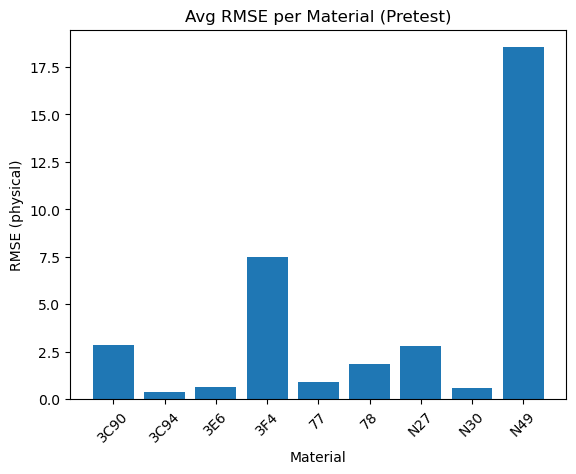

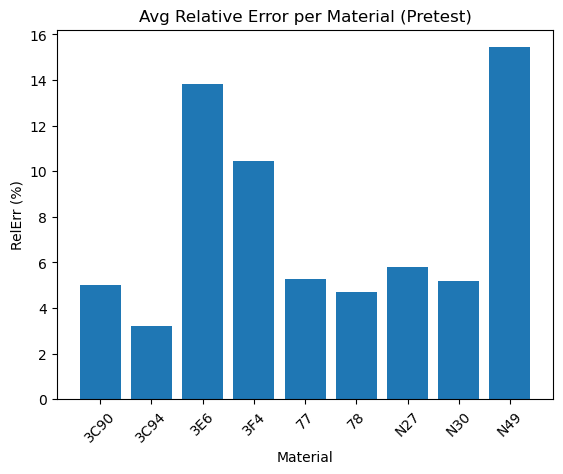

In [3]:
# ============================================================
# GLOBAL MODEL PRETEST EVAL + PLOTS (ALL-IN-ONE, NO SAVES)
# - Computes global normalization stats from training CSVs
# - Loads trained global model
# - Evaluates PRETEST H5 files (group-aware + root fallback)
# - Filters bad/padded windows to avoid crazy spikes
# - Correct RelErr computed in physical units (includes mean)
# - Shows plots:
#     * Measured vs Predicted curves (few segments per material)
#     * RMSE bar chart per material
#     * RelErr bar chart per material
# ============================================================

import os
import math
import random
from typing import Optional, Tuple, List, Dict

import numpy as np
import torch
import torch.nn as nn
import h5py
import pandas as pd
from tqdm import tqdm
from pandas.errors import EmptyDataError
import matplotlib.pyplot as plt


# ============================================================
# Config
# ============================================================
DEVICE = torch.device("cpu")
print("Device:", DEVICE)

TRAIN_ROOT   = "/Users/Ankan/Desktop/Magnet_Challenge_2/Training Data/78/Training Data"
PRETEST_ROOT = "/Users/Ankan/Desktop/Magnet_Challenge_2/Training Data/78/Pretest"
MODEL_PATH   = "/Users/Ankan/Desktop/Magnet_Challenge_2/Training Data/78/Training Data/global_lstm_model.pt"

TRAIN_MATERIALS   = ["3C90", "3C94", "3E6", "3F4", "77", "78",
                     "N27", "N30", "N49", "N87"]

PRETEST_MATERIALS = ["3C90", "3C94", "3E6", "3F4", "77", "78",
                     "N27", "N30", "N49", "N87", "N87-2"]

MATERIAL_ALIAS = {"N87-2": "N87"}

FREQS      = [1, 2, 3, 4, 5, 6, 7]
SEQ_LEN    = 80

# Speed knobs
STRIDE = 20
MAX_WINDOWS = 3000

# Frequency handling
USE_FREQ_AVG = True
FREQ_FOR_PRETEST = 4
FREQ_TO_IDX = {f: i for i, f in enumerate(FREQS)}

# Filters (important for removing padding/flat segments)
EPS_STD_B = 1e-6
EPS_STD_H = 1e-6
MAX_ABS_NORM = 1e6

# Plot controls
PLOT_MAX_SEGMENTS_PER_MAT = 2     # how many segments per material to plot
PLOT_MAX_POINTS = 400             # how many points per curve to show


# ============================================================
# Repro
# ============================================================
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# ============================================================
# Safe CSV loader
# ============================================================
def load_1d_csv(path: str) -> Optional[np.ndarray]:
    try:
        if os.path.getsize(path) == 0:
            return None
    except OSError:
        return None

    try:
        arr = pd.read_csv(path, header=None).values.squeeze()
    except EmptyDataError:
        return None
    except Exception as e:
        print(f"⚠️ Failed to read {os.path.basename(path)}: {type(e).__name__}")
        return None

    arr = np.asarray(arr, dtype=np.float32).reshape(-1)
    if arr.size == 0:
        return None
    return arr


# ============================================================
# Global normalization from training CSVs
# ============================================================
def compute_global_normalisation(root, materials, freqs):
    all_B, all_H, all_dB = [], [], []
    used = 0
    skipped_empty = 0
    skipped_missing = 0

    print("\n📌 Computing global normalisation stats from training CSVs...")
    for mat in tqdm(materials, desc="Materials"):
        mat_dir = os.path.join(root, mat)
        if not os.path.isdir(mat_dir):
            skipped_missing += 1
            continue

        for f in freqs:
            B_path = os.path.join(mat_dir, f"{mat}_{f}_B.csv")
            H_path = os.path.join(mat_dir, f"{mat}_{f}_H.csv")
            T_path = os.path.join(mat_dir, f"{mat}_{f}_T.csv")

            if not (os.path.exists(B_path) and os.path.exists(H_path) and os.path.exists(T_path)):
                skipped_missing += 1
                continue

            B = load_1d_csv(B_path)
            H = load_1d_csv(H_path)
            T = load_1d_csv(T_path)

            if B is None or H is None or T is None:
                skipped_empty += 1
                continue

            n = min(len(B), len(H), len(T))
            if n <= 2:
                skipped_empty += 1
                continue

            B = B[:n]
            H = H[:n]
            dBdt = np.gradient(B).astype(np.float32)

            all_B.append(B)
            all_H.append(H)
            all_dB.append(dBdt)
            used += 1

    if used == 0:
        raise RuntimeError(
            f"No valid (B,H,T) triplets found.\n"
            f"TRAIN_ROOT={root}\n"
            f"skipped_missing={skipped_missing}, skipped_empty={skipped_empty}"
        )

    B_cat = np.concatenate(all_B)
    H_cat = np.concatenate(all_H)
    dB_cat = np.concatenate(all_dB)

    stats = {
        "B_mean": float(B_cat.mean()),
        "B_std":  float(B_cat.std() + 1e-8),
        "H_mean": float(H_cat.mean()),
        "H_std":  float(H_cat.std() + 1e-8),
        "dB_mean": float(dB_cat.mean()),
        "dB_std":  float(dB_cat.std() + 1e-8),
    }

    print(f"\nUsed triplets: {used}")
    print(f"Skipped missing: {skipped_missing}")
    print(f"Skipped empty/bad: {skipped_empty}")

    print("\nGlobal stats:")
    for k, v in stats.items():
        print(f"  {k}: {v:.6f}")

    return stats


# ============================================================
# Build windows with filtering
# ============================================================
def build_windows_from_segment(B, H, stats, seq_len=80, stride=20, max_windows=3000):
    B = np.asarray(B, dtype=np.float32).reshape(-1)
    H = np.asarray(H, dtype=np.float32).reshape(-1)

    n = min(len(B), len(H))
    B, H = B[:n], H[:n]

    good = np.isfinite(B) & np.isfinite(H)
    if good.sum() < (seq_len + 2):
        return None, None

    B = B[good]
    H = H[good]
    n = len(B)
    if n <= seq_len + 1:
        return None, None

    dBdt = np.gradient(B).astype(np.float32)

    Bn  = (B    - stats["B_mean"])  / stats["B_std"]
    Hn  = (H    - stats["H_mean"])  / stats["H_std"]
    dBn = (dBdt - stats["dB_mean"]) / stats["dB_std"]

    if (np.abs(Bn).max() > MAX_ABS_NORM) or (np.abs(Hn).max() > MAX_ABS_NORM) or (np.abs(dBn).max() > MAX_ABS_NORM):
        return None, None

    starts = list(range(0, n - seq_len, stride))
    if max_windows is not None and len(starts) > max_windows:
        starts = starts[:max_windows]

    inputs, targets = [], []
    for start in starts:
        end = start + seq_len
        if end >= n:
            break

        Bw = B[start:end]
        Hw = H[start:end]
        if np.std(Bw) < EPS_STD_B or np.std(Hw) < EPS_STD_H:
            continue

        x = np.stack([Bn[start:end], Hn[start:end], dBn[start:end]], axis=-1)
        y = Hn[end]
        if not np.isfinite(x).all() or not np.isfinite(y):
            continue

        inputs.append(x)
        targets.append(y)

    if not inputs:
        return None, None

    return np.stack(inputs).astype(np.float32), np.asarray(targets, dtype=np.float32)


# ============================================================
# H5 helpers
# ============================================================
def is_real_hdf5(path: str) -> bool:
    try:
        return os.path.exists(path) and h5py.is_hdf5(path)
    except Exception:
        return False

def diagnose_bad_h5(path: str) -> str:
    if not os.path.exists(path):
        return "missing"
    sz = os.path.getsize(path)
    if sz == 0:
        return "0 bytes"
    try:
        with open(path, "rb") as f:
            head = f.read(16)
    except Exception:
        return "unreadable"
    if head.startswith(b"PK\x03\x04") or head.startswith(b"PK\x05\x06") or head.startswith(b"PK\x07\x08"):
        return "ZIP renamed as .h5"
    low = head.lower()
    if b"<html" in low or b"<!doct" in low:
        return "HTML redirect"
    return "not HDF5"


def find_root_BH_datasets(h5file):
    keys = list(h5file.keys())

    preferred_B = ["B_seq", "B", "b_seq", "b"]
    preferred_H = ["H_seq", "H", "h_seq", "h"]

    B_key = next((k for k in preferred_B if k in keys), None)
    H_key = next((k for k in preferred_H if k in keys), None)

    if B_key is None or H_key is None:
        low = {k: k.lower() for k in keys}
        B_cand = [k for k in keys if ("b" in low[k]) and ("db" not in low[k])]
        H_cand = [k for k in keys if ("h" in low[k]) and ("dh" not in low[k])]
        if not B_cand or not H_cand:
            raise RuntimeError(f"Cannot identify B/H datasets at root. Keys={keys}")
        B_key = sorted(B_cand)[0]
        H_key = sorted(H_cand)[0]

    print(f"   Using ROOT datasets: B='{B_key}', H='{H_key}'")
    return h5file[B_key], h5file[H_key]


# ============================================================
# Model (must match training)
# ============================================================
class GlobalLSTM(nn.Module):
    def __init__(
        self,
        n_materials: int,
        n_freqs: int,
        input_dim: int = 3,
        hidden_dim: int = 32,
        mat_emb_dim: int = 4,
        freq_emb_dim: int = 2,
        num_layers: int = 1,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.mat_emb = nn.Embedding(n_materials, mat_emb_dim)
        self.freq_emb = nn.Embedding(n_freqs, freq_emb_dim)
        self.fc = nn.Linear(hidden_dim + mat_emb_dim + freq_emb_dim, 1)

    def forward(self, x, mat_idx, freq_idx):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        m_vec = self.mat_emb(mat_idx)
        f_vec = self.freq_emb(freq_idx)
        feat = torch.cat([last, m_vec, f_vec], dim=-1)
        return self.fc(feat).squeeze(-1)


# ============================================================
# Prediction helper + plots
# ============================================================
def predict_windows(model, X_norm, y_norm, stats, mat_idx_val: int):
    X = torch.from_numpy(X_norm).to(DEVICE)
    y = np.asarray(y_norm, dtype=np.float32)

    mat_idx = torch.full((len(X),), mat_idx_val, dtype=torch.long, device=DEVICE)

    # predict normalized
    if USE_FREQ_AVG:
        preds_all = []
        with torch.no_grad():
            for fi in range(len(FREQS)):
                freq_idx = torch.full((len(X),), fi, dtype=torch.long, device=DEVICE)
                preds_all.append(model(X, mat_idx, freq_idx).cpu().numpy())
        preds = np.mean(np.stack(preds_all, axis=0), axis=0)
    else:
        fi = FREQ_TO_IDX[FREQ_FOR_PRETEST]
        freq_idx = torch.full((len(X),), fi, dtype=torch.long, device=DEVICE)
        with torch.no_grad():
            preds = model(X, mat_idx, freq_idx).cpu().numpy()

    # physical
    y_phys = y * stats["H_std"] + stats["H_mean"]
    preds_phys = preds * stats["H_std"] + stats["H_mean"]

    rmse = float(np.sqrt(np.mean((preds_phys - y_phys) ** 2)))
    rms_meas = float(np.sqrt(np.mean((y_phys) ** 2)))
    rel_err = rmse / (rms_meas + 1e-12) * 100.0

    return rmse, rel_err, len(X_norm), y_phys, preds_phys


def plot_meas_vs_pred(material: str, seg_label, y_phys: np.ndarray, preds_phys: np.ndarray, rmse: float, rel_err: float):
    n = min(len(y_phys), PLOT_MAX_POINTS)
    plt.figure()
    plt.plot(y_phys[:n])
    plt.plot(preds_phys[:n])
    plt.xlabel("Window index")
    plt.ylabel("H (physical)")
    plt.title(f"{material} seg={seg_label} | RMSE={rmse:.3f} | RelErr={rel_err:.2f}%")
    plt.legend(["Measured", "Predicted"])
    plt.show()


# ============================================================
# PRETEST evaluation per material
# ============================================================
def evaluate_pretest_material(material, model, stats):
    true_path = os.path.join(PRETEST_ROOT, material, f"{material}_Testing_True.h5")
    pad_path  = os.path.join(PRETEST_ROOT, material, f"{material}_Testing_Padded.h5")

    chosen = None
    for p in [true_path, pad_path]:
        if is_real_hdf5(p):
            chosen = p
            break

    if chosen is None:
        d1 = diagnose_bad_h5(true_path)
        d2 = diagnose_bad_h5(pad_path)
        print(f"⚠️ [{material}] No valid HDF5 file. True={d1} | Padded={d2} — skipping")
        return []

    print(f"\n=== Evaluating PRETEST for {material} using {os.path.basename(chosen)} ===")
    rows = []

    # material id
    mat_lookup = MATERIAL_ALIAS.get(material, material)
    if mat_lookup in TRAIN_MATERIALS:
        mat_idx_val = TRAIN_MATERIALS.index(mat_lookup)
    else:
        print(f"⚠️ [{material}] not in TRAIN_MATERIALS and no alias match — skipping")
        return []

    plots_done = 0

    with h5py.File(chosen, "r") as f:
        group_names = [k for k in f.keys() if isinstance(f[k], h5py.Group)]
        group_names = sorted(group_names)
        print(f"Found groups: {group_names}")

        # CASE A: groups exist
        if group_names:
            for gname in tqdm(group_names, desc=f"{material} groups", leave=False):
                grp = f[gname]
                keys = list(grp.keys())
                low = {k: k.lower() for k in keys}

                B_cand = [k for k in keys if ("b" in low[k]) and ("db" not in low[k])]
                H_cand = [k for k in keys if ("h" in low[k]) and ("dh" not in low[k])]
                if not B_cand or not H_cand:
                    continue

                bkey = sorted(B_cand)[0]
                hkey = sorted(H_cand)[0]

                B_seg = np.array(grp[bkey][:], dtype=np.float32)
                H_seg = np.array(grp[hkey][:], dtype=np.float32)

                X_norm, y_norm = build_windows_from_segment(
                    B_seg, H_seg, stats,
                    seq_len=SEQ_LEN, stride=STRIDE, max_windows=MAX_WINDOWS
                )
                if X_norm is None:
                    continue

                rmse, rel_err, nwin, y_phys, preds_phys = predict_windows(model, X_norm, y_norm, stats, mat_idx_val)

                rows.append({
                    "material": material,
                    "segment": gname,
                    "n_windows": int(nwin),
                    "rmse": rmse,
                    "rel_err": rel_err,
                    "file_used": os.path.basename(chosen)
                })

                if plots_done < PLOT_MAX_SEGMENTS_PER_MAT:
                    plot_meas_vs_pred(material, gname, y_phys, preds_phys, rmse, rel_err)
                    plots_done += 1

        # CASE B: no groups -> root datasets
        else:
            try:
                B_ds, H_ds = find_root_BH_datasets(f)
            except RuntimeError as e:
                print(f"  {e} — skipping {material}")
                return rows

            shape = B_ds.shape

            if len(shape) == 1:
                B_seg = np.array(B_ds[:], dtype=np.float32)
                H_seg = np.array(H_ds[:], dtype=np.float32)

                X_norm, y_norm = build_windows_from_segment(
                    B_seg, H_seg, stats,
                    seq_len=SEQ_LEN, stride=STRIDE, max_windows=MAX_WINDOWS
                )
                if X_norm is not None:
                    rmse, rel_err, nwin, y_phys, preds_phys = predict_windows(model, X_norm, y_norm, stats, mat_idx_val)
                    rows.append({
                        "material": material,
                        "segment": "root",
                        "n_windows": int(nwin),
                        "rmse": rmse,
                        "rel_err": rel_err,
                        "file_used": os.path.basename(chosen)
                    })
                    if plots_done < PLOT_MAX_SEGMENTS_PER_MAT:
                        plot_meas_vs_pred(material, "root", y_phys, preds_phys, rmse, rel_err)
                        plots_done += 1

            elif len(shape) == 2:
                n_segments = shape[0]
                for seg_idx in tqdm(range(n_segments), desc=f"{material} segments (root)", leave=False):
                    B_seg = np.array(B_ds[seg_idx], dtype=np.float32)
                    H_seg = np.array(H_ds[seg_idx], dtype=np.float32)

                    X_norm, y_norm = build_windows_from_segment(
                        B_seg, H_seg, stats,
                        seq_len=SEQ_LEN, stride=STRIDE, max_windows=MAX_WINDOWS
                    )
                    if X_norm is None:
                        continue

                    rmse, rel_err, nwin, y_phys, preds_phys = predict_windows(model, X_norm, y_norm, stats, mat_idx_val)

                    rows.append({
                        "material": material,
                        "segment": int(seg_idx),
                        "n_windows": int(nwin),
                        "rmse": rmse,
                        "rel_err": rel_err,
                        "file_used": os.path.basename(chosen)
                    })

                    if plots_done < PLOT_MAX_SEGMENTS_PER_MAT:
                        plot_meas_vs_pred(material, int(seg_idx), y_phys, preds_phys, rmse, rel_err)
                        plots_done += 1
            else:
                print(f"  Unsupported dataset shape at root: {shape} — skipping")

    return rows


# ============================================================
# Summary plots
# ============================================================
def plot_summary_bars(summary_df: pd.DataFrame):
    # RMSE bar
    plt.figure()
    plt.bar(summary_df["material"], summary_df["rmse"])
    plt.xlabel("Material")
    plt.ylabel("RMSE (physical)")
    plt.title("Avg RMSE per Material (Pretest)")
    plt.xticks(rotation=45)
    plt.show()

    # RelErr bar
    plt.figure()
    plt.bar(summary_df["material"], summary_df["rel_err"])
    plt.xlabel("Material")
    plt.ylabel("RelErr (%)")
    plt.title("Avg Relative Error per Material (Pretest)")
    plt.xticks(rotation=45)
    plt.show()


# ============================================================
# MAIN
# ============================================================
def main():
    set_seed(42)

    # 1) global stats
    stats = compute_global_normalisation(TRAIN_ROOT, TRAIN_MATERIALS, FREQS)

    # 2) load global model
    model = GlobalLSTM(
        n_materials=len(TRAIN_MATERIALS),
        n_freqs=len(FREQS),
        input_dim=3,
        hidden_dim=32,
        mat_emb_dim=4,
        freq_emb_dim=2,
        num_layers=1,
    ).to(DEVICE)

    # Safer torch.load
    try:
        state = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)
    except TypeError:
        state = torch.load(MODEL_PATH, map_location=DEVICE)

    model.load_state_dict(state)
    model.eval()
    print("\nModel loaded.")

    # 3) run pretest
    all_rows = []
    for mat in tqdm(PRETEST_MATERIALS, desc="PRETEST materials"):
        all_rows.extend(evaluate_pretest_material(mat, model, stats))

    if not all_rows:
        print("\n⚠️ No results collected — check paths / H5 validity!")
        return

    df = pd.DataFrame(all_rows)

    print("\n================ PRETEST RESULTS (per segment) ================")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    summary = (
        df.groupby("material")[["rmse", "rel_err"]]
        .mean()
        .reset_index()
        .sort_values("material")
    )

    print("\n================ PRETEST SUMMARY (avg per material) ===========")
    print(summary.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

    # 4) summary plots
    plot_summary_bars(summary)


if __name__ == "__main__":
    main()
